<div class="alert alert-block alert-info">
    <font size=5>
        What drives the price of a car?
    </font>
</div>

<div class="alert alert-block alert-success">
    <font size=3>
        FlowChart
    </font>
</div>

<img src="images/Flowchart.svg" alt="Flowchart" width="2000">

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [91]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import requests,json

In [92]:
df = pd.read_csv("data/vehicles_v2.csv")

In [93]:
df.shape

(370678, 17)

In [94]:
df.sample(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
303231,hilton head,39990,2020.0,acura,mdx sh-awd sport utility,good,6,gas,1237.0,clean,other,5J8YD4H39LL041518,4wd,NaN,other,white,sc
64370,denver,46900,NaN,ford,Explorer,NaN,6,gas,14853.0,clean,automatic,1FM5K7D86JGB47937,fwd,NaN,SUV,blue,co
178218,lansing,8500,2009.0,jaguar,xf,excellent,8,gas,133000.0,clean,automatic,SAJWA06BX9HR40788,rwd,mid-size,sedan,red,mi
105663,atlanta,3000,2013.0,chevrolet,cruze ls,fair,4,gas,112000.0,rebuilt,automatic,NaN,NaN,NaN,sedan,black,ga
34827,orange county,8999,1988.0,mercedes-benz,560 sl,good,8,gas,122000.0,clean,automatic,NaN,rwd,NaN,NaN,red,ca


In [95]:
(df.isna().sum() / df.shape[0] *100).round(2)

region           0.00
price            0.00
year             0.27
manufacturer     3.33
model            1.26
condition       38.11
cylinders       16.41
fuel             0.10
odometer         0.94
title_status     1.83
transmission     0.48
VIN             38.60
drive           26.46
size            71.46
type            15.90
paint_color     29.36
state            0.00
dtype: float64

# Reuse Functions

In [96]:
def plotkde(_plot_df):
    fix, ax = plt.subplots(figsize=(10, 3))
    _dia = sns.kdeplot(_plot_df, ax=ax, color='royalblue')
    _dia.set_title(f"{_plot_df.columns[0].title()}-Density", fontsize=20)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.set_label(_plot_df.columns[0])

    plt.savefig(f"images/{_plot_df.columns[0]}_count_kdeplot.png")
    plt.show()
    

def histplot(df, xaxis, hue, title):
    
    _group = df.groupby([xaxis, hue]).size().reset_index(name="count").sort_values(by="count", ascending=False)

    fig, ax = plt.subplots(layout="constrained", figsize=(20, 5))
    rects = sns.barplot(data=_group, x=xaxis, y="count", hue=hue)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(xaxis.title(), fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(title, fontsize=20)
    
    plt.xticks(rotation=30, ha='center', va='top')
    plt.savefig(f"images/{xaxis}_{hue}_count_barplot.png")
    plt.show()

def violinplot(df, xaxis, yaxis):    
    fig, ax = plt.subplots(layout="constrained", figsize=(10, 5))
    sns.violinplot(x = xaxis, y = yaxis, data = df.fillna('NA'), hue = xaxis);
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(xaxis.title(), fontsize=14)
    ax.set_ylabel(yaxis.title(), fontsize=14)
    ax.set_title(f"{xaxis.title()} -> {yaxis.title()}", fontsize=20)
    
    plt.xticks(rotation=30, ha='center', va='top')
    plt.savefig(f"images/{xaxis}_count.png")
    plt.show()

    a = (df[xaxis].value_counts(normalize=True, dropna=False)*100).round(2)
    b = df.groupby(xaxis, dropna=False)['price'].describe().round(2)
    
    return pd.DataFrame(pd.concat([a.rename("Percent"), b], axis=1))
    
    
def infosnapshot(df):
    na_count = df.isna().sum()
    na_pct = (df.isna().sum() / df.shape[0] *100).round(2)
    data_types = df.dtypes
    unique_count = df.nunique()
    return pd.concat([data_types.rename("Data Types"), na_count.rename("NA Count"), na_pct.rename("NA Percent"),unique_count.rename("Unique Count")], axis=1)     

<div class="alert alert-block alert-success">
    <font size=6>
        Cleaning 
    </font>
    <p>
    Focus on this section will be on<br> 
    * Drop Columns which will not contribute to model fitting<br>
    * Removing Duplicates<br>
    * Deleting the rows which have unrelaistic data points e.g price<=0<br>
    * Type casting<br>    
    * Modifying text data uniformly<br>        
    </p>
</div>

![](images/Cleaning.svg)

### Drop VIN as they are unique identifiers

In [97]:
df.drop(columns=["VIN"], inplace=True)

In [98]:
df['model'].nunique()

29649

##### Feature, `model` is a free text with almost 30K unique values. This will not be contributing to modeling

In [99]:
df.drop(columns=["model"], inplace=True)

### Check for duplicate

In [100]:
df.duplicated().sum()

1171

### Removal of Duplicate

In [101]:
df = df[~df.duplicated()]
df.duplicated().sum()

0

In [102]:
df.shape

(369507, 15)

## Check for Null Values

In [103]:
infosnapshot(df)

,Data Types,NA Count,NA Percent,Unique Count
region,object,0,0.00,404
price,int64,0,0.00,15655
year,float64,986,0.27,114
manufacturer,object,12302,3.33,42
condition,object,140410,38.00,6
cylinders,object,60646,16.41,8
fuel,object,350,0.09,5
odometer,float64,3405,0.92,104870
title_status,object,6690,1.81,6
transmission,object,1731,0.47,3


In [104]:
df[df.manufacturer.isna() & df.condition.isna() & df.cylinders.isna() & df.fuel.isna() & df.transmission.isna()].sample(5)

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
17,skagit / island / SJI,21850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wa
209315,raleigh / durham / CH,0,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
6278,fairbanks,23300,1975.0,NaN,NaN,NaN,NaN,17500.0,clean,NaN,NaN,NaN,other,custom,ak
69087,fort collins / north CO,32300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,co
256973,cleveland,15789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,oh


In [105]:
len(df[df.manufacturer.isna() & df.condition.isna() & df.cylinders.isna() & df.fuel.isna() & df.transmission.isna()])

75

In [106]:
df[df.manufacturer.isna() & df.condition.isna() & df.cylinders.isna() & df.drive.isna() & df.type.isna()].sample(5)

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
89325,orlando,0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
212874,lincoln,35000,2015.0,NaN,NaN,NaN,gas,1600.0,clean,manual,NaN,NaN,NaN,NaN,ne
120297,chicago,0,2014.0,NaN,NaN,NaN,diesel,100.0,clean,automatic,NaN,NaN,NaN,NaN,il
212869,lincoln,34500,2007.0,NaN,NaN,NaN,diesel,97000.0,clean,automatic,NaN,NaN,NaN,NaN,ne
206095,greensboro,0,2012.0,NaN,NaN,NaN,diesel,1.0,clean,manual,NaN,NaN,NaN,white,nc


In [107]:
len(df[df.manufacturer.isna() & df.condition.isna() & df.cylinders.isna() & df.drive.isna() & df.type.isna()])

2425

## Removing all rows where key features are NA

In [108]:
df.dropna(subset=['manufacturer', 'condition','cylinders', 'fuel' ,'transmission'], axis= 0, inplace=True, how='all')
df.shape

(369432, 15)

In [109]:
df.dropna(subset=['manufacturer', 'condition','cylinders', 'drive' ,'type'], axis= 0, inplace=True, how='all')
df.shape

(367078, 15)

## Describe and check the distribution of data

In [110]:
df.describe()

,price,year,odometer
count,3.670780e+05,366150.000000,3.637490e+05
mean,8.478089e+04,2011.118858,9.667590e+04
std,1.313710e+07,9.709994,2.062798e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.995000e+03,2008.000000,3.576200e+04
50%,1.447500e+04,2013.000000,8.344300e+04
75%,2.699000e+04,2017.000000,1.331370e+05
max,3.736929e+09,2022.000000,1.000000e+07


## Cosmetic Changes

In [111]:
df.loc[:,'state'] = df['state'].apply(lambda x: x.upper())

In [112]:
df.loc[:,'region'] = df['region'].map(lambda x: x.title(),na_action='ignore')

In [113]:
df.loc[:,'manufacturer'] = df['manufacturer'].map(lambda x: x.title(),na_action='ignore')

In [114]:
df.replace({"cylinders": {'other':'0'}}, inplace=True)
df['cylinders'].unique()

array(['8', '6', '4', nan, '3', '5', '0', '10', '12'], dtype=object)

In [115]:
df.sample(5)

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
97182,South Florida,78000,2012.0,NaN,good,NaN,diesel,421202.0,clean,manual,NaN,NaN,truck,white,FL
367257,Milwaukee,9995,2005.0,Chevrolet,NaN,NaN,diesel,297054.0,clean,automatic,4wd,NaN,NaN,NaN,WI
308987,Knoxville,0,2020.0,Nissan,NaN,NaN,gas,22884.0,clean,automatic,4wd,NaN,SUV,white,TN
258138,Columbus,1900,2005.0,Hyundai,good,6,gas,230000.0,clean,automatic,NaN,NaN,NaN,NaN,OH
88993,Okaloosa / Walton,23990,2015.0,Toyota,excellent,6,gas,85364.0,clean,automatic,rwd,mid-size,truck,grey,FL


<div class="alert alert-block alert-success">
    <font size=6>
        Exploratory data analysis (EDA) 
    </font>
    <p>
    Focus on this section will be on<br> 
    * Removal of Outliers
    * Plot<br>
    * Analysis of data<br>
    </p>
</div>
### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.                                    

![](images/EDA.svg)

## Remove all Price and odometer which are less than or equal to 0 and then remove outliers.

- #### Its Seen that Min price is 0 and max is ridiculously high, Thus we might have to ckean up the data first
- #### Same for Odometer Min is 0 and Max is too high.
- #### Even though the Outlier count w.r.t year is 15K, Its worth noting The price 3 decade back will have almost no influence on present trend

In [116]:
count = len(df[df['price']<=0])
total = df.shape[0]
print(f"Count: {count}, Percent: {count/total*100}")

Count: 25199, Percent: 6.864753540119539


In [117]:
count = len(df[df['odometer']<=0])
total = df.shape[0]
print(f"Count: {count}, Percent: {count/total*100}")

Count: 1582, Percent: 0.4309710742675944


In [118]:
len(df[(df['price']<1000) & (df['odometer']<1000)])

1901

In [119]:
df_pos = df[(df['price']>1000) & (df['odometer']>1000)]
count = len(df_pos)
total = df.shape[0]
print(f"Count: {count}, Percent: {count/total*100}")

Count: 323110, Percent: 88.02216422667662


In [120]:
df_pos.shape

(323110, 15)

## Removing outliers (using IQR)

In [121]:
iqr = df_pos['price'].quantile(.75) - df_pos['price'].quantile(.25)				
iqr				

20000.0

In [122]:
lower_bound = df_pos['price'].quantile(.25) - 1.5 * iqr				
upper_bound = df_pos['price'].quantile(.75) + 1.5 * iqr
total_outliers_price = df_pos.shape[0]-(df_pos[(df_pos['price'] > lower_bound) & (df_pos['price'] < upper_bound)]['year'].count())
print(f"Price\n\tLower Bound: {lower_bound} \n\tUpper Bound: {upper_bound}\n\tTotal Outliers: {total_outliers_price}")

Price
	Lower Bound: -22005.0 
	Upper Bound: 57995.0
	Total Outliers: 6772


In [123]:
iqr_odo = df_pos['odometer'].quantile(.75) - df_pos['odometer'].quantile(.25)				
iqr_odo	

97697.0

In [124]:
lower_bound_odo = df_pos['odometer'].quantile(.25) - 1.5 * iqr_odo				
upper_bound_odo = df_pos['odometer'].quantile(.75) + 1.5 * iqr_odo	
total_outliers_odo = df_pos.shape[0]-(df_pos[(df_pos['odometer'] > lower_bound_odo) & (df_pos['odometer'] < upper_bound_odo)]['year'].count())
print(f"Odometer\n\tLower Bound: {lower_bound_odo} \n\tUpper Bound: {upper_bound_odo}\n\tTotal Outliers: {total_outliers_odo}")

Odometer
	Lower Bound: -107745.5 
	Upper Bound: 283042.5
	Total Outliers: 3833


In [125]:
iqr_year = df_pos['year'].quantile(.75) - df_pos['year'].quantile(.25)				
iqr_year	

9.0

In [126]:
lower_bound_year = df_pos['year'].quantile(.25) - 1.5 * iqr_year				
upper_bound_year = df_pos['year'].quantile(.75) + 1.5 * iqr_year	
total_outliers_year = df_pos.shape[0]-(df_pos[(df_pos['year'] > lower_bound_year) & (df_pos['year'] < upper_bound_year)]['year'].count())
print(f"Year\n\tLower Bound: {lower_bound_year} \n\tUpper Bound: {upper_bound_year}\n\tTotal Outliers: {total_outliers_year}")

Year
	Lower Bound: 1994.5 
	Upper Bound: 2030.5
	Total Outliers: 13420


In [127]:
df_iqr = df_pos[(df_pos['price'] > lower_bound) & (df_pos['price'] < upper_bound) & 
                (df_pos['odometer'] > lower_bound_odo) & (df_pos['odometer'] < upper_bound_odo) & 
                (df_pos['year'] > lower_bound_year) & (df_pos['year'] < upper_bound_year) ]

In [128]:
df_pos.shape[0] - df_iqr.shape[0]

21644

In [129]:
len(df_iqr)/len(df_pos)*100				

93.30135248057937

Roughly 21644 records were outliers which is approx 7%

## Reset DataFrame

In [130]:
df = df_iqr

In [131]:
infosnapshot(df)

,Data Types,NA Count,NA Percent,Unique Count
region,object,0,0.00,404
price,int64,0,0.00,13249
year,float64,0,0.00,28
manufacturer,object,5835,1.94,40
condition,object,103939,34.48,6
cylinders,object,44831,14.87,8
fuel,object,209,0.07,5
odometer,float64,0,0.00,91441
title_status,object,4540,1.51,6
transmission,object,981,0.33,3


In [132]:
df.shape

(301466, 15)

#### At this time we have cleaned approx 14% of data after deduping

## Plot

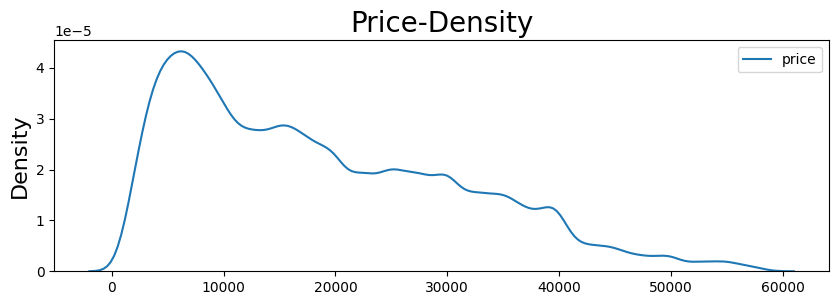

In [133]:
plotkde(df[['price']])

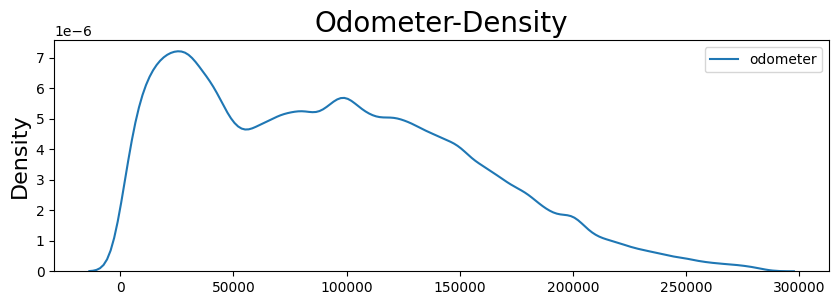

In [134]:
plotkde(df[['odometer']])

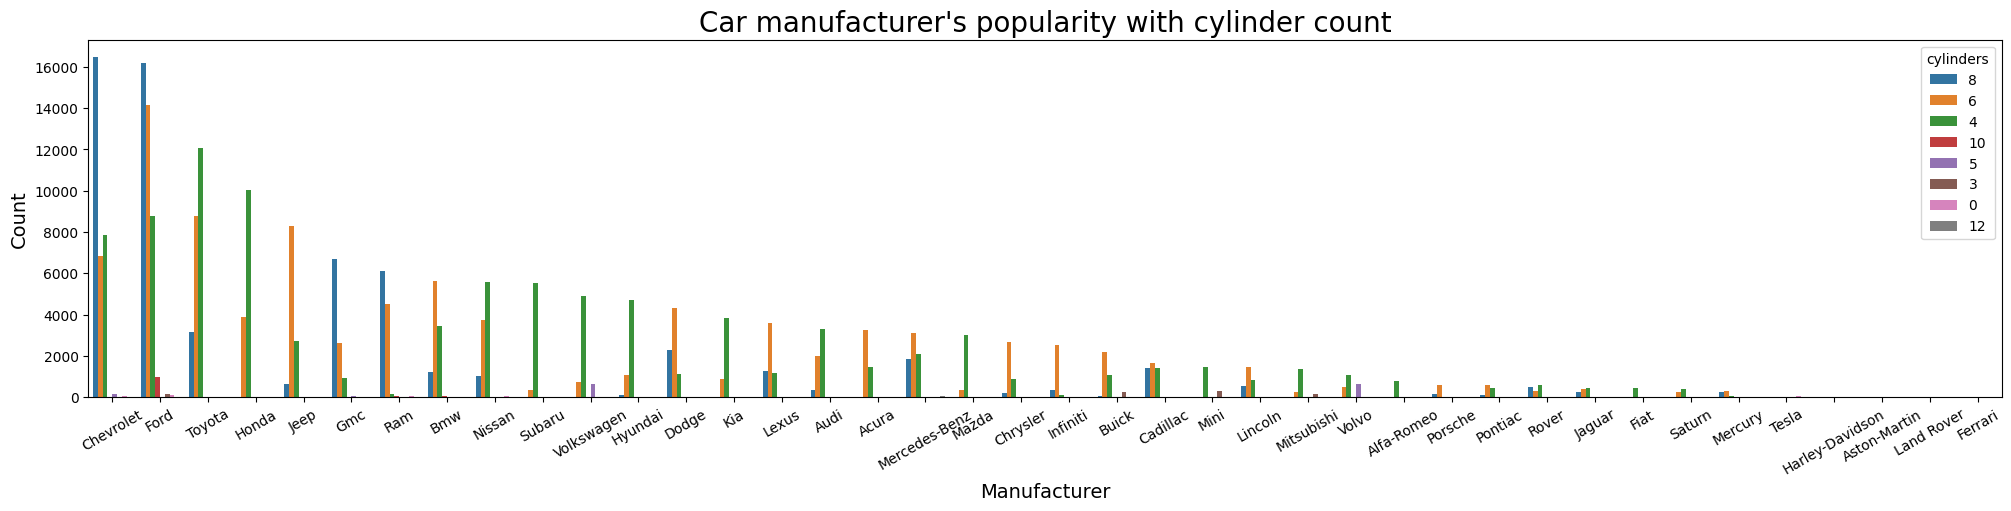

In [135]:
histplot(df, "manufacturer", "cylinders", "Car manufacturer's popularity with cylinder count")

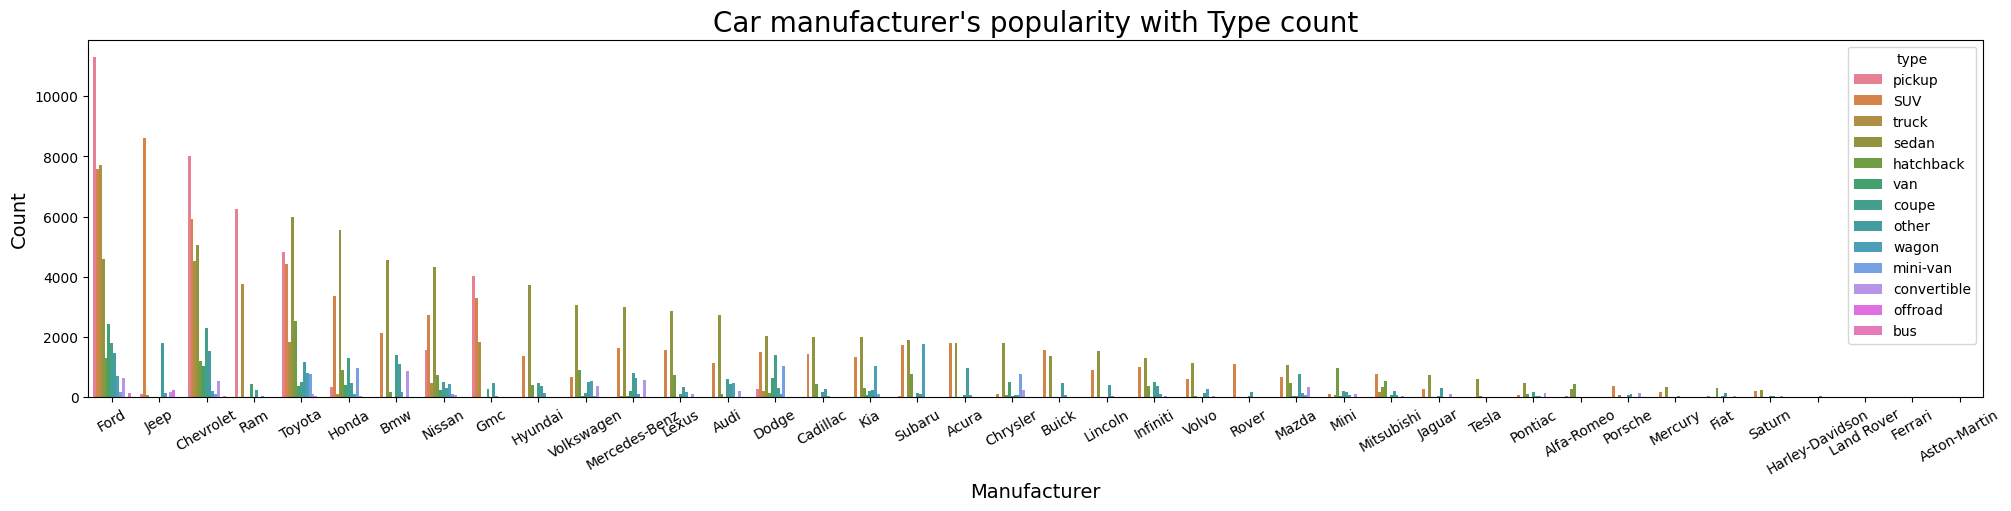

In [136]:
histplot(df, "manufacturer", "type", "Car manufacturer's popularity with Type count")

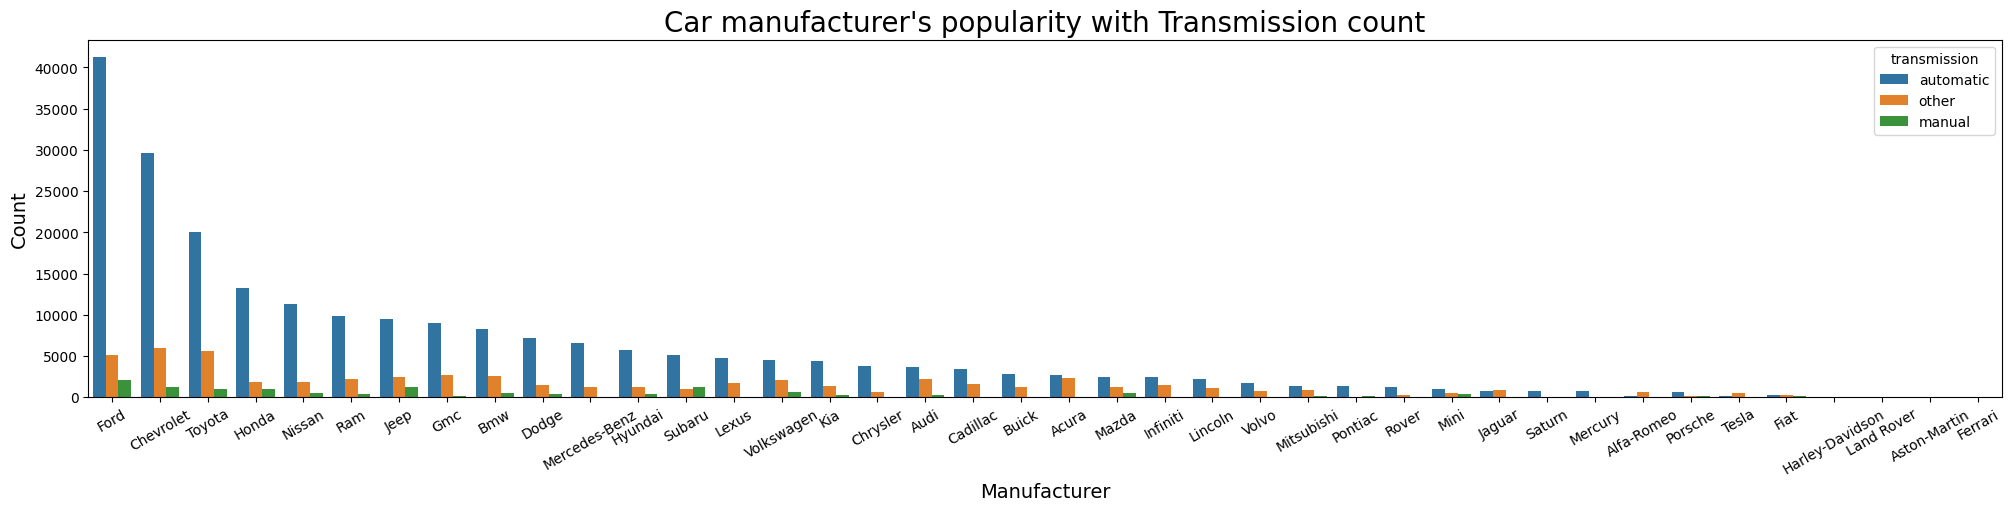

In [137]:
histplot(df, "manufacturer", "transmission", "Car manufacturer's popularity with Transmission count")

## Check what data is in each column

In [138]:
m_count = (df.manufacturer.value_counts(normalize=True, dropna=False)*100).round(2)
m_count.iloc[:10,]

manufacturer
Ford         16.17
Chevrolet    12.25
Toyota        8.86
Honda         5.35
Nissan        4.61
Jeep          4.38
Ram           4.14
Gmc           3.90
Bmw           3.79
Dodge         3.01
Name: proportion, dtype: float64

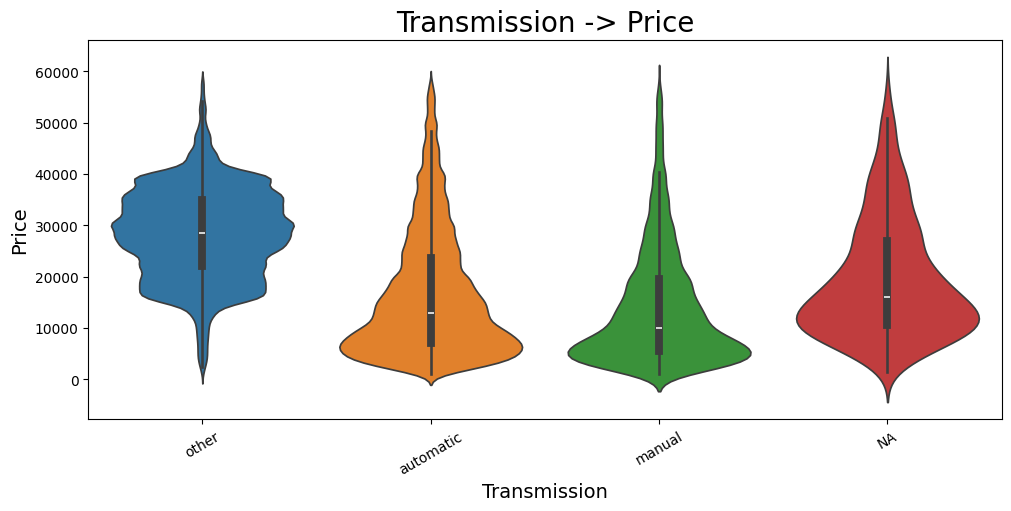

,Percent,count,mean,std,min,25%,50%,75%,max
transmission,,,,,,,,,
automatic,75.75,228349.0,16637.52,12177.14,1003.0,6995.0,12999.0,23590.0,57993.0
other,19.27,58099.0,28458.60,8876.91,1199.0,21990.0,28590.0,34990.0,57990.0
manual,4.66,14037.0,14011.93,11338.06,1050.0,5500.0,10000.0,19500.0,57900.0
NaN,0.33,981.0,19419.48,11545.74,1400.0,10500.0,15995.0,26988.0,56990.0


In [139]:
violinplot(df, "transmission", "price")

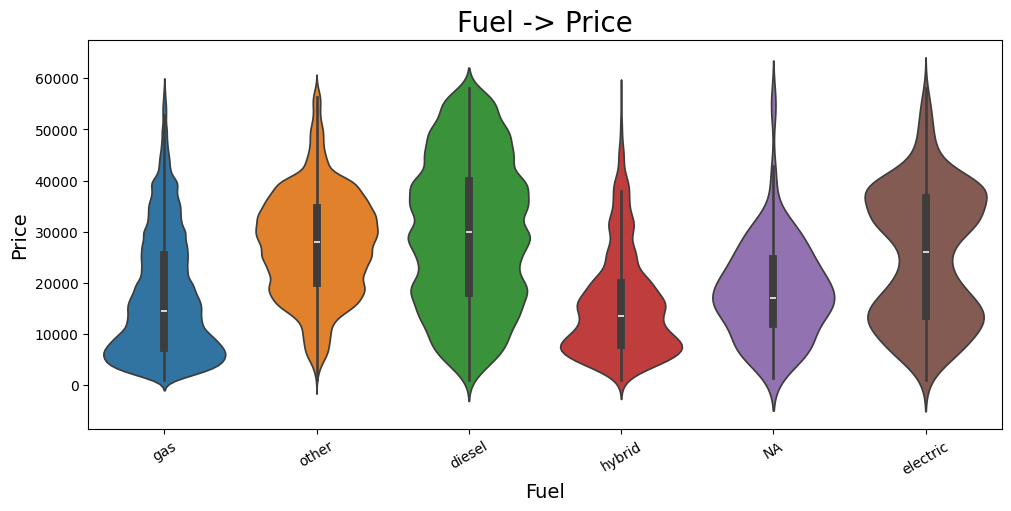

,Percent,count,mean,std,min,25%,50%,75%,max
fuel,,,,,,,,,
gas,84.52,254784.0,17280.21,11913.99,1004.0,7300.0,14500.0,25500.0,57991.0
other,7.99,24086.0,27540.47,10104.90,1062.0,19990.0,27990.0,34590.0,57990.0
diesel,5.58,16826.0,29621.92,14216.18,1003.0,17991.0,29900.0,39999.0,57993.0
hybrid,1.39,4200.0,15618.21,9957.04,1095.0,7950.0,13590.0,19990.0,55995.0
electric,0.45,1361.0,25276.83,12873.70,1004.0,13500.0,25990.0,36590.0,57991.0
NaN,0.07,209.0,18360.59,9379.58,1500.0,11995.0,16995.0,24754.0,57000.0


In [140]:
violinplot(df, "fuel", "price")

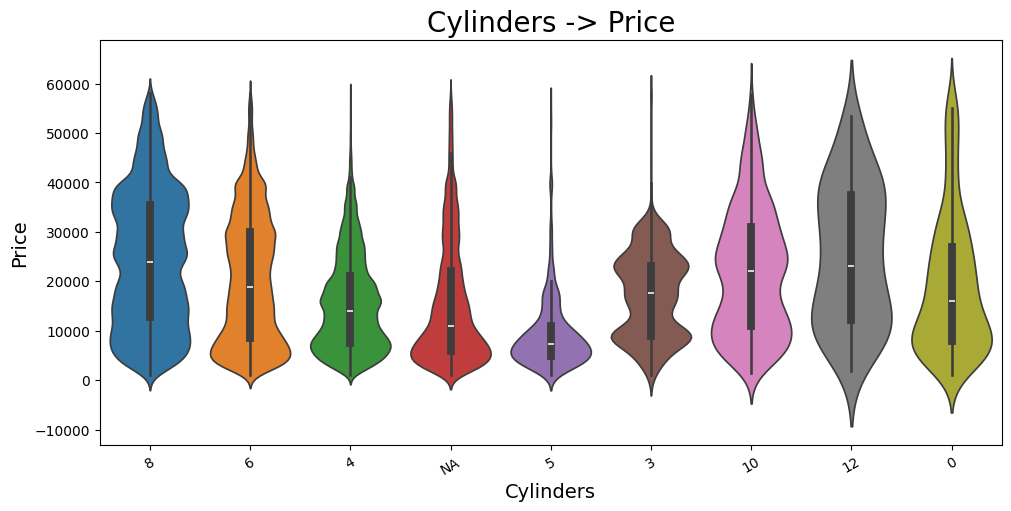

,Percent,count,mean,std,min,25%,50%,75%,max
cylinders,,,,,,,,,
4,31.70,95551.0,15503.87,9587.07,1090.0,7600.0,13992.0,20999.0,57990.0
6,31.10,93746.0,20134.60,12836.54,1006.0,8490.0,18782.0,29990.0,57990.0
8,20.72,62466.0,24538.37,13784.27,1003.0,12800.0,24000.0,35499.0,57993.0
NaN,14.87,44831.0,15371.26,12137.14,1004.0,5991.0,11000.0,21990.0,57991.0
5,0.59,1767.0,9266.99,7064.25,1100.0,4800.0,7250.0,10995.0,56000.0
3,0.40,1200.0,17302.29,8655.03,1100.0,8990.0,17590.0,22990.0,57500.0
10,0.38,1133.0,21878.82,12723.68,1500.0,10900.0,21990.0,30900.0,57895.0
0,0.22,673.0,19348.04,14075.98,1100.0,8000.0,15995.0,26999.0,57500.0
12,0.03,99.0,25206.21,14134.41,1947.0,12200.0,23000.0,37497.0,53500.0


In [141]:
violinplot(df, "cylinders", "price")

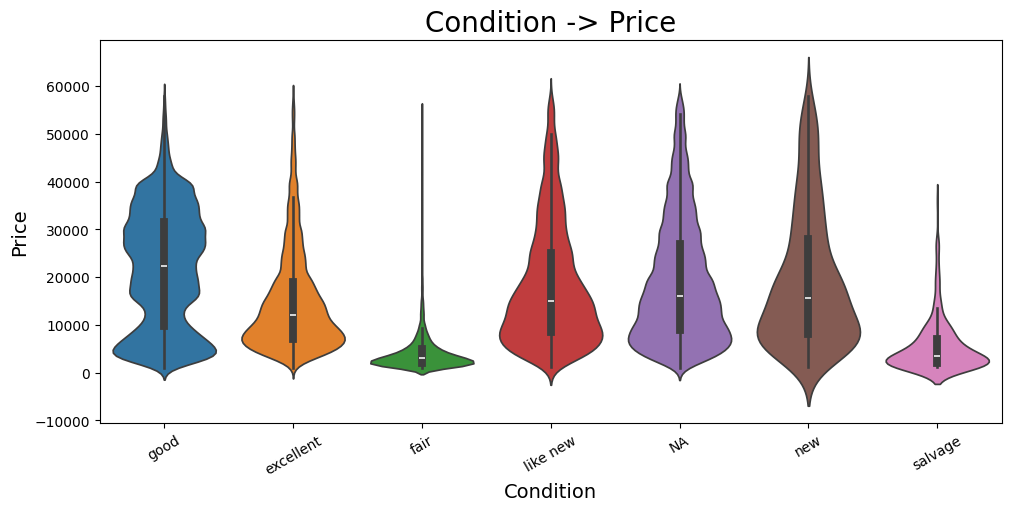

,Percent,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,,
good,35.08,105757.0,21732.77,12532.43,1004.0,9800.0,22400.0,31590.0,57990.0
NaN,34.48,103939.0,19185.04,12882.77,1003.0,8900.0,15995.0,26999.0,57993.0
excellent,23.72,71516.0,14888.71,10430.67,1012.0,7100.0,11995.0,19000.0,57988.0
like new,5.13,15458.0,18330.29,12548.25,1095.0,8500.0,14995.0,25075.0,57990.0
fair,1.32,3982.0,4047.13,3665.76,1050.0,2000.0,3000.0,4900.0,55000.0
new,0.17,507.0,19542.46,14195.91,1234.0,8000.0,15699.0,28000.0,57900.0
salvage,0.10,307.0,5515.14,5441.01,1100.0,2000.0,3500.0,7000.0,35989.0


In [142]:
violinplot(df, "condition", "price")

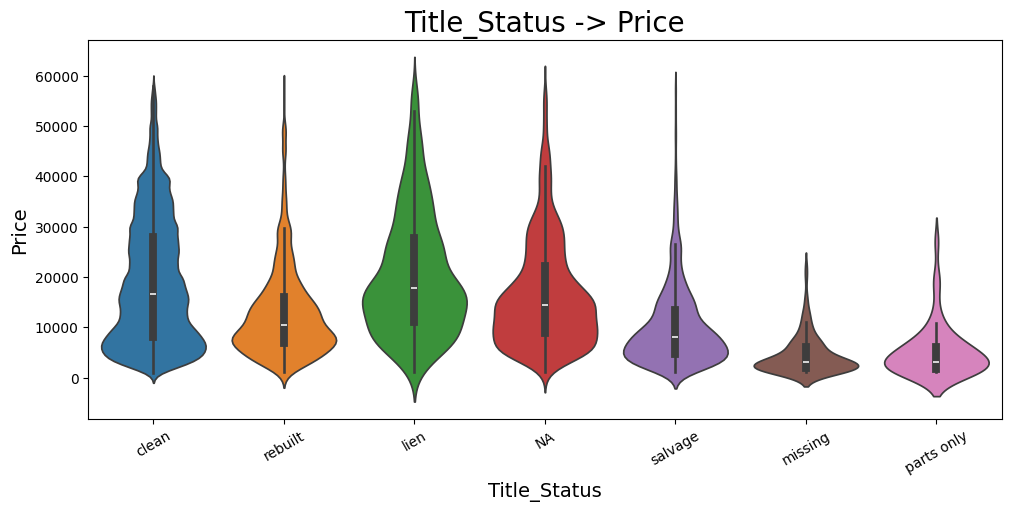

,Percent,count,mean,std,min,25%,50%,75%,max
title_status,,,,,,,,,
clean,94.92,286163.0,19060.98,12574.32,1003.0,7999.0,16614.0,27995.00,57993.0
rebuilt,2.05,6192.0,12844.01,8908.24,1100.0,6800.0,10550.0,16000.00,57000.0
NaN,1.51,4540.0,16666.61,10698.89,1055.0,8788.0,14373.0,22232.25,57988.0
salvage,1.04,3140.0,10248.15,8142.45,1100.0,4600.0,7995.0,13500.00,57500.0
lien,0.41,1251.0,20423.67,12204.71,1100.0,11000.0,17790.0,27814.00,57875.0
missing,0.04,131.0,4460.53,3781.58,1100.0,2000.0,3000.0,6000.00,21999.0
parts only,0.02,49.0,5249.63,5215.18,1100.0,1800.0,3000.0,6000.00,27000.0


In [143]:
violinplot(df, "title_status", "price")

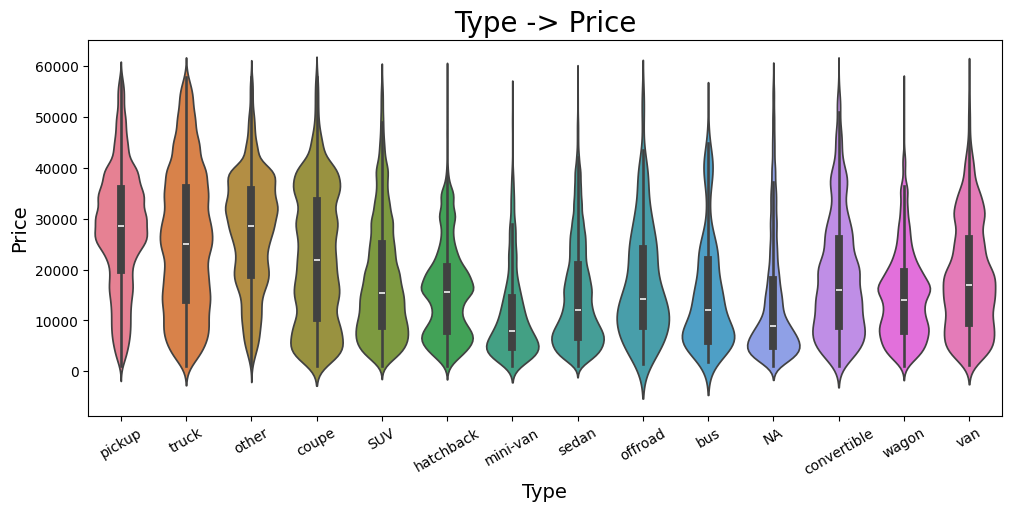

,Percent,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,,
sedan,22.53,67920.0,14882.03,10285.21,1050.0,6800.00,11995.0,20990.0,57991.0
SUV,20.26,61062.0,17907.30,11470.60,1004.0,8852.25,15495.0,24995.0,57990.0
NaN,14.42,43467.0,13279.05,11605.50,1050.0,4995.00,8900.0,17946.0,57991.0
pickup,12.25,36937.0,27926.18,11935.33,1014.0,19995.00,28495.0,35837.0,57993.0
truck,7.30,22008.0,25671.74,13849.39,1003.0,13998.00,24995.0,35999.0,57988.0
other,5.44,16408.0,27492.48,11141.47,1093.0,18999.00,28590.0,35590.0,57990.0
hatchback,4.78,14415.0,15720.79,9137.80,1100.0,7988.00,15590.0,20590.0,57977.0
coupe,4.59,13824.0,22253.79,13075.93,1051.0,10500.00,21900.0,33590.0,57990.0
wagon,2.70,8137.0,14821.24,8583.24,1100.0,7995.00,13995.0,19495.0,55337.0


In [144]:
violinplot(df, "type", "price")

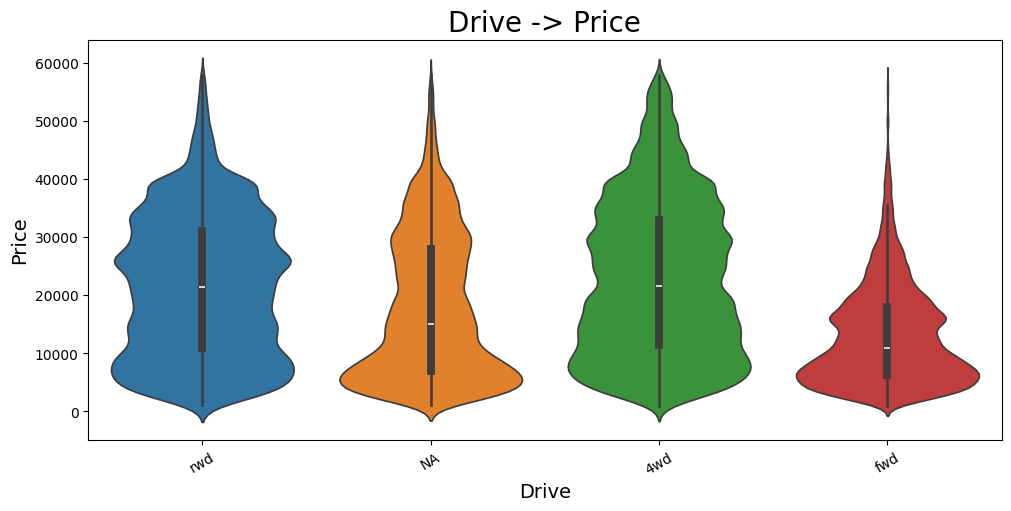

,Percent,count,mean,std,min,25%,50%,75%,max
drive,,,,,,,,,
4wd,33.36,100575.0,22936.64,13419.57,1003.0,11400.0,21590.0,32995.0,57993.0
fwd,27.03,81487.0,13054.29,8562.79,1012.0,6300.0,10995.0,17990.0,57500.0
NaN,25.69,77451.0,17994.13,12480.91,1050.0,6995.0,14999.0,27990.0,57991.0
rwd,13.92,41953.0,21548.96,12209.12,1100.0,10899.0,21500.0,30990.0,57990.0


In [145]:
violinplot(df, "drive", "price")

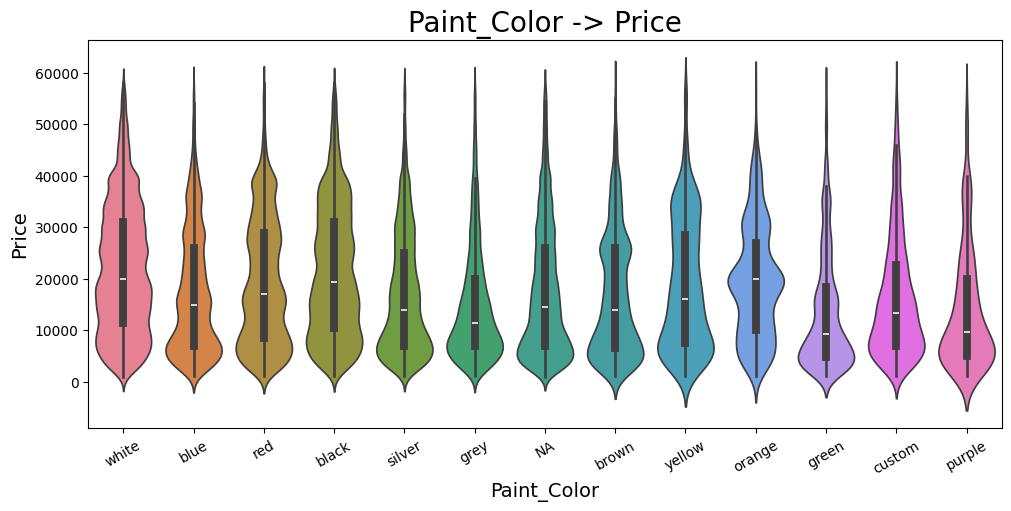

,Percent,count,mean,std,min,25%,50%,75%,max
paint_color,,,,,,,,,
NaN,26.71,80509.0,17610.39,12704.86,1003.0,6995.00,14439.0,25995.0,57993.0
white,19.39,58469.0,21940.53,12538.07,1012.0,11500.00,20000.0,30990.0,57988.0
black,15.77,47544.0,21268.30,12669.47,1050.0,10490.75,19379.5,30990.0,57991.0
silver,11.01,33185.0,16959.38,11652.95,1100.0,7000.00,13999.0,24998.0,57990.0
blue,7.70,23227.0,17327.36,11868.60,1100.0,6999.00,14995.0,25990.0,57981.0
red,7.45,22452.0,19340.48,12199.43,1057.0,8500.00,16995.0,28949.0,57990.0
grey,6.02,18142.0,14918.90,10995.29,1100.0,6900.00,11500.0,19995.0,57990.0
green,1.71,5147.0,13452.23,11241.09,1100.0,4900.00,9200.0,18400.0,57000.0
brown,1.63,4920.0,16699.63,11882.62,1050.0,6499.00,13900.0,25990.0,57950.0


In [146]:
# m_color = (df.paint_color.value_counts(normalize=True, dropna=False)*100).round(2)
# m_color
violinplot(df, "paint_color", "price")

In [147]:
m_size = (df['size'].value_counts(normalize=True, dropna=False)*100).round(2)
m_size

size
NaN            71.60
full-size      14.71
mid-size        8.50
compact         4.48
sub-compact     0.72
Name: proportion, dtype: float64

In [148]:
a = pd.DataFrame(df.groupby('state')['state'].value_counts()).sort_values(by='count', ascending=False)
a.loc[a['count']>=6000].count()


count    20
dtype: int64

## Something isn't right

In [149]:
df[(df.fuel=='electric')&(df.cylinders!='other')].groupby(['cylinders'])[['cylinders']].count()

,cylinders
cylinders,
0,142
4,145
6,12
8,7


- Electric card do not have 'cylinders'

In [856]:
df[(df.fuel=='electric')&(df.cylinders.notna()) &(df.cylinders!='other')]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
3163,Huntsville / Decatur,28998,2018.0,Mercedes-Benz,NaN,4,electric,26908.0,clean,automatic,NaN,compact,sedan,white,AL
6005,Anchorage / Mat-Su,54000,2018.0,Tesla,excellent,0,electric,16000.0,clean,automatic,4wd,full-size,sedan,white,AK
6508,Southeast Alaska,6999,2012.0,Nissan,good,0,electric,62102.0,clean,automatic,fwd,compact,hatchback,black,AK
6569,Southeast Alaska,24995,2019.0,Nissan,like new,0,electric,5650.0,clean,automatic,fwd,NaN,other,white,AK
7713,Phoenix,10991,2012.0,Toyota,good,4,electric,136117.0,clean,automatic,fwd,NaN,hatchback,NaN,AZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364515,Madison,13666,2013.0,Chevrolet,NaN,4,electric,53903.0,clean,other,fwd,NaN,sedan,NaN,WI
364796,Madison,36995,2015.0,Tesla,good,0,electric,62560.0,clean,automatic,4wd,NaN,hatchback,blue,WI
364918,Madison,43470,2018.0,Volvo,excellent,4,electric,39149.0,clean,automatic,4wd,NaN,sedan,white,WI
365560,Madison,6999,2013.0,Nissan,good,0,electric,60038.0,clean,automatic,fwd,NaN,NaN,NaN,WI


- Above are Hybrid Cars 

## Conclusions of EDA
1. In total there were 53K records which are **not** considered in model fitting as more than half has un realistic data where price and odometer reading erre less than equal to 0. Rest of the records were outliers.
2. About 72% of 'size' column is NA, thus that will not be contributing to model fitting.
3. There is good corelation between. Some combinination clearly dominate.
   - manufacturer - cylinders
   - manufacturer - type
4. About 94% of cars have 'title_status' status. We can consider to make it a boolean field. with either clean status or not.

In [857]:
df.to_csv('data/vehicles_v3.csv', index=False)

<div class="alert alert-block alert-success">
    <font size=5>
        This concludes the Cleaning and EDA. The data to be analyzed is now saved in separate CSV "data/vehicles_v3.csv". <br>Please continue to "03_profiling.ipynb"
    </font>
</div>

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

# Model Reference
- 04_model_1.ipynb
  - Model 1: PolynomialFeatures
- 05_model_2_3.ipynb
  - Model 2: Transformation + PolynomialFeature (all fields) + Linear Regression
  - Model 3: Transformation + PolynomialFeature (4 fields) + Linear Regression
- 06_model_4_5_6.ipynb
  - Model 4: Transformation + PolynomialFeature (4 fields) + SequentialFeatureSelector (15 features) + Linear Regression
  - Model 5: Transformation + PolynomialFeature (4 fields) + SequentialFeatureSelector (20 features) + Linear Regression
  - Model 6: Transformation + PolynomialFeature (4 fields) + SequentialFeatureSelector (30 features) + Linear Regression
- 07_model_7_8_9.ipynb
  - Model 7: Transformation + PolynomialFeature (4 fields) + SelectFromModel(Lasso()) + Linear Regression
  - Model 8: Transformation + PolynomialFeature (4 fields) + Lasso (20 features)
  - Model 9: Transformation + PolynomialFeature (4 fields) + SelectFromModel(Lasso(), max_features=75) + Linear Regression
- 08_model_10_11.ipynb
  - Model 7: Transformation + PolynomialFeature (4 fields) + Ridge (default alpha)
  - Model 8: Transformation + PolynomialFeature (4 fields) + Ridge (alpha=10)